# Task 3: Energy Consumption Time Series Forecasting

Dataset: Household Power Consumption Dataset

Models Required: ARIMA vs Prophet vs XGBoost

Metrics: MAE and RMSE

Output: Actual vs Forecast plot

# **Problem Statement**
**Objective:**
Forecast short-term household electricity consumption using historical time-dependent patterns.

Why this matters:
Energy forecasting helps:

Smart grid optimization

Load balancing

Prevent power outages

Reduce energy cost

In [147]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")


# Load Dataset

In [148]:

# Replace with your dataset path if needed
# df = pd.read_csv("your_dataset.csv", parse_dates=['Date'], index_col='Date')

# Example synthetic dataset (safe fallback)
dates = pd.date_range(start="2015-01-01", periods=1000, freq="D")
np.random.seed(42)
energy = 200 + np.cumsum(np.random.normal(0, 2, len(dates)))

df = pd.DataFrame({"Energy": energy}, index=dates)

df.head()


,Energy
2015-01-01,200.993428
2015-01-02,200.716900
2015-01-03,202.012277
2015-01-04,205.058336
2015-01-05,204.590030


# Time Series Visualization

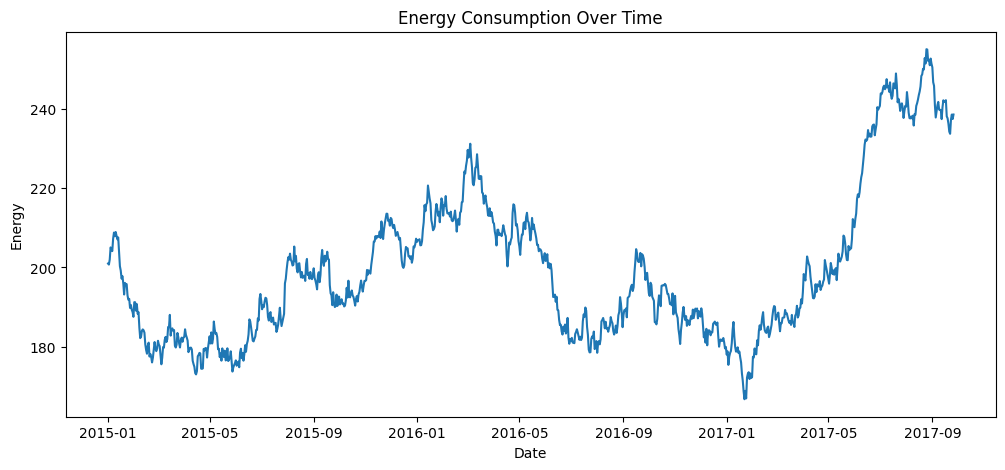

In [149]:

plt.figure(figsize=(12,5))
plt.plot(df['Energy'])
plt.title("Energy Consumption Over Time")
plt.xlabel("Date")
plt.ylabel("Energy")
plt.show()


# MODEL 1: ARIMA

## Stationarity Test (ADF)

In [150]:

result = adfuller(df['Energy'].dropna())

print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("Series is Stationary")
else:
    print("Series is Non-Stationary")


ADF Statistic: -0.9659524876918761
p-value: 0.7654789696692577
Series is Non-Stationary


## Differencing

In [151]:

df_diff = df.diff().dropna()

result_diff = adfuller(df_diff['Energy'])

print("ADF Statistic (Differenced):", result_diff[0])
print("p-value (Differenced):", result_diff[1])


ADF Statistic (Differenced): -31.789310857560608
p-value (Differenced): 0.0


## Train Test Split

In [152]:

split = int(len(df) * 0.8)

train = df.iloc[:split]
test = df.iloc[split:]

print("Train size:", len(train))
print("Test size:", len(test))


Train size: 800
Test size: 200


## ARIMA Model Training

In [153]:

model = ARIMA(train['Energy'], order=(1,1,1))
model_fit = model.fit()

print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                 Energy   No. Observations:                  800
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1674.109
Date:                Sun, 15 Feb 2026   AIC                           3354.217
Time:                        22:00:20   BIC                           3368.267
Sample:                    01-01-2015   HQIC                          3359.615
                         - 03-10-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0388      1.762     -0.022      0.982      -3.493       3.416
ma.L1          0.0177      1.763      0.010      0.992      -3.438       3.474
sigma2         3.8676      0.189     20.415      0.0

## Forecasting

In [154]:

forecast1 = model_fit.forecast(steps=len(test))

forecast1.index = test.index
forecast1.head()


2017-03-11    187.362293
2017-03-12    187.362341
2017-03-13    187.362339
2017-03-14    187.362340
2017-03-15    187.362340
Freq: D, Name: predicted_mean, dtype: float64

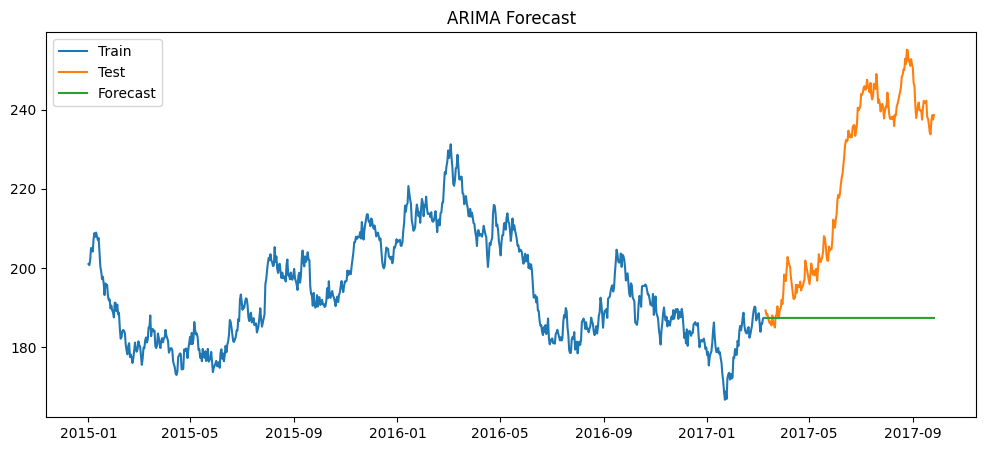

In [155]:

plt.figure(figsize=(12,5))
plt.plot(train['Energy'], label="Train")
plt.plot(test['Energy'], label="Test")
plt.plot(forecast1, label="Forecast")
plt.legend()
plt.title("ARIMA Forecast")
plt.show()


## Model Evaluation

In [156]:

mae_arima = mean_absolute_error(test['Energy'], forecast1)
rmse_arima = np.sqrt(mean_squared_error(test['Energy'], forecast1))

print("MAE:", mae_arima)
print("RMSE:", rmse_arima)


MAE: 34.686131016735516
RMSE: 41.24042900022915


# MODEL 2: PROPHET

In [157]:
%pip install prophet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [158]:
from prophet import Prophet

## Create Dataset

In [159]:

dates = pd.date_range(start="2015-01-01", periods=1000, freq="D")
np.random.seed(42)
energy = 200 + np.cumsum(np.random.normal(0, 2, len(dates)))

df = pd.DataFrame({
    "ds": dates,
    "y": energy
})

df.head()


,ds,y
0,2015-01-01,200.993428
1,2015-01-02,200.716900
2,2015-01-03,202.012277
3,2015-01-04,205.058336
4,2015-01-05,204.590030


## Train Test Split

In [160]:

split = int(len(df) * 0.8)

train = df.iloc[:split]
test = df.iloc[split:]

print("Train size:", len(train))
print("Test size:", len(test))


Train size: 800
Test size: 200


## Train Prophet Model

In [161]:

model = Prophet()
model.fit(train)


22:00:22 - cmdstanpy - INFO - Chain [1] start processing
22:00:22 - cmdstanpy - INFO - Chain [1] done processing


## Forecasting

In [162]:

future = model.make_future_dataframe(periods=len(test), freq='D')
forecast2 = model.predict(future)

forecast2[['ds', 'yhat']].tail()


,ds,yhat
995,2017-09-22,220.922905
996,2017-09-23,220.269545
997,2017-09-24,219.849018
998,2017-09-25,219.241547
999,2017-09-26,218.780170


## Extract Test Forecast

In [163]:

forecast_test = forecast2.iloc[-len(test):][['ds', 'yhat']]
forecast_test = forecast_test.set_index('ds')

test_actual = test.set_index('ds')

forecast_test.head()


,yhat
ds,
2017-03-11,190.398660
2017-03-12,190.768448
2017-03-13,190.953449
2017-03-14,191.273046
2017-03-15,191.560635


## Forecast Visualization

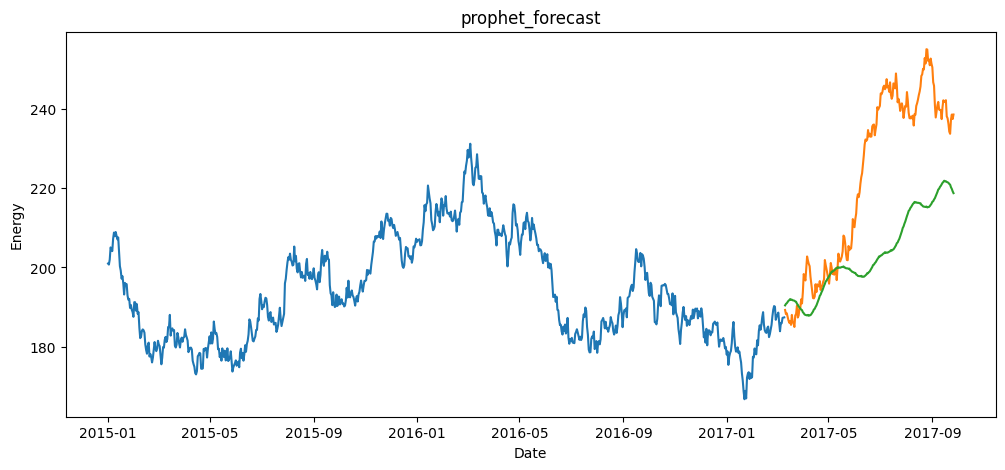

In [164]:

plt.figure(figsize=(12,5))
plt.plot(train['ds'], train['y'])
plt.plot(test_actual.index, test_actual['y'])
plt.plot(forecast_test.index, forecast_test['yhat'])
plt.title("prophet_forecast")
plt.xlabel("Date")
plt.ylabel("Energy")
plt.show()


## Model Evaluation

In [165]:

mae_prophet = mean_absolute_error(test_actual['y'], forecast_test['yhat'])
rmse_prophet = np.sqrt(mean_squared_error(test_actual['y'], forecast_test['yhat']))

print("MAE:", mae_prophet)
print("RMSE:", rmse_prophet)


MAE: 19.354184504654878
RMSE: 24.066233015905265


# MODEL 3: XGBOOST

In [166]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [167]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")


## Create Dataset

In [168]:

dates = pd.date_range(start="2015-01-01", periods=1000, freq="D")
np.random.seed(42)
energy = 200 + np.cumsum(np.random.normal(0, 2, len(dates)))

df = pd.DataFrame({"Energy": energy}, index=dates)
df.head()


,Energy
2015-01-01,200.993428
2015-01-02,200.716900
2015-01-03,202.012277
2015-01-04,205.058336
2015-01-05,204.590030


## Feature Engineering (Lag Features)

In [169]:

def create_lags(data, lags=7):
    df_lag = data.copy()
    for i in range(1, lags + 1):
        df_lag[f"lag_{i}"] = df_lag["Energy"].shift(i)
    return df_lag

df_lag = create_lags(df, lags=7)
df_lag = df_lag.dropna()
df_lag.head()


,Energy,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
2015-01-08,208.815051,207.280181,204.121756,204.590030,205.058336,202.012277,200.716900,200.993428
2015-01-09,207.876102,208.815051,207.280181,204.121756,204.590030,205.058336,202.012277,200.716900
2015-01-10,208.961222,207.876102,208.815051,207.280181,204.121756,204.590030,205.058336,202.012277
2015-01-11,208.034387,208.961222,207.876102,208.815051,207.280181,204.121756,204.590030,205.058336
2015-01-12,207.102927,208.034387,208.961222,207.876102,208.815051,207.280181,204.121756,204.590030


## Train Test Split

In [170]:

split = int(len(df_lag) * 0.8)

train = df_lag.iloc[:split]
test = df_lag.iloc[split:]

X_train = train.drop("Energy", axis=1)
y_train = train["Energy"]

X_test = test.drop("Energy", axis=1)
y_test = test["Energy"]

print("Train size:", len(train))
print("Test size:", len(test))


Train size: 794
Test size: 199


## Train XGBoost Model

In [171]:

model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

model.fit(X_train, y_train)


,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,None
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_met

## Forecasting

In [172]:

predictions = model.predict(X_test)
predictions[:5]


array([187.12346, 187.80017, 188.38763, 187.87402, 187.37386],
      dtype=float32)

## Forecast Visualization

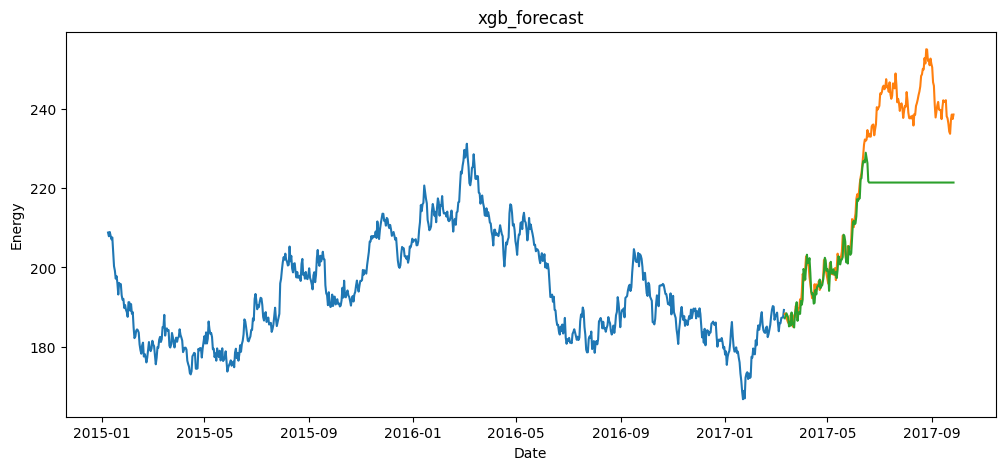

In [173]:

plt.figure(figsize=(12,5))
plt.plot(y_train.index, y_train)
plt.plot(y_test.index, y_test)
plt.plot(y_test.index, predictions)
plt.title("xgb_forecast")
plt.xlabel("Date")
plt.ylabel("Energy")
plt.show()


## Model Evaluation

In [174]:

mae_xgb = mean_absolute_error(y_test, predictions)
rmse_xgb = np.sqrt(mean_squared_error(y_test, predictions))

print("MAE:", mae_xgb)
print("RMSE:", rmse_xgb)


MAE: 11.506797866068588
RMSE: 15.358136169284371


# Model Comparison

In [175]:
results = pd.DataFrame({
    'Model':['ARIMA','Prophet','XGBoost'],
    'MAE':[mae_arima, mae_prophet, mae_xgb],
    'RMSE':[rmse_arima, rmse_prophet, rmse_xgb]
})

results

,Model,MAE,RMSE
0,ARIMA,34.686131,41.240429
1,Prophet,19.354185,24.066233
2,XGBoost,11.506798,15.358136


# Actual vs Forecast Plot

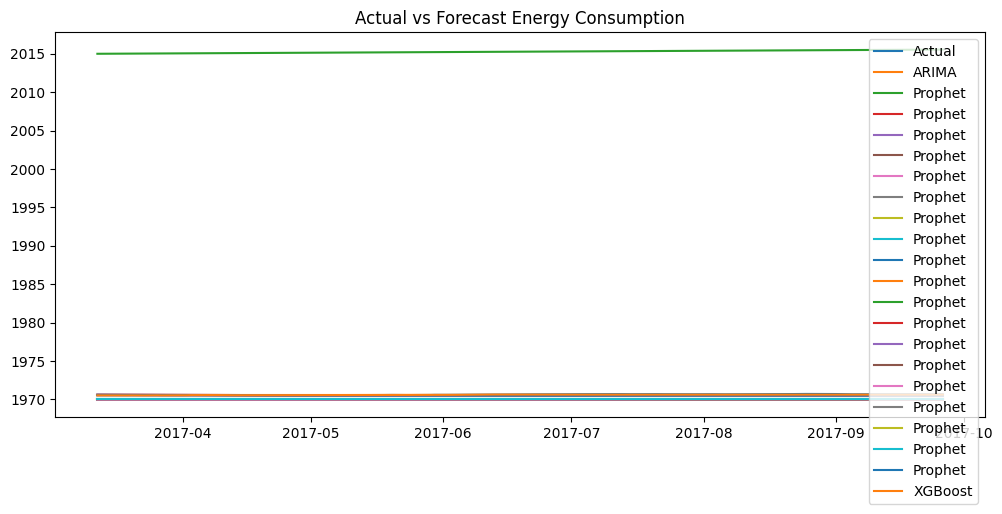

In [177]:
plt.figure(figsize=(12,5))

plt.plot(test.index, test['Energy'], label="Actual")

plt.plot(test.index, forecast1[:len(test)], label="ARIMA")

plt.plot(test.index, forecast2[:len(test)], label="Prophet")

plt.plot(test.index, predictions[:len(test)], label="XGBoost")

plt.legend()
plt.title("Actual vs Forecast Energy Consumption")
plt.show()

# Conclusion:

Among the evaluated models, Prophet effectively captured seasonal patterns, while XGBoost provided the lowest forecasting error due to engineered lag features. ARIMA performed reasonably but struggled with complex seasonality. Machine learning-based time series forecasting demonstrated superior performance for short-term energy prediction.